학습과정은 생략하고, 추론 과정만 구현해보도록 한다. 데이터셋은 유명한 MNIST 데이터셋이다.

# 3.6.1 MNIST 데이터셋

* 기계학습에서 매우 유명한 데이터셋
* 0 ~ 9의 숫자 이미지들로 구성
* shape: 28 x 28 x 1
* train 6만장, test 1만장

책에서는 깃허브에서 가져오라고 하는데, 그러지 말고 그냥 keras에 내장되어 있는 함수를 이용해본다. 왜냐면 편하기 때문이다.

In [17]:
import keras.datasets.mnist as mnist

dataset = mnist.load_data()

In [27]:
len(dataset)
len(dataset[0])
len(dataset[0][0]) # train_x
len(dataset[0][1]) # train_y
len(dataset[1][0])
dataset[1][1].shape

(10000,)

데이터셋을 살펴보는 Tip

* len함수를 이용하여 몇 개로 나눠지는지 확인하기
* ? 기호를 이용하여, 변수에 어떻게 할당할지 구상해보기
* shape를 이용하여 모양 살펴보기

In [4]:
# len(dataset)
# len(dataset[0])
# ?mnist.load_data

In [40]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [37]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


load_data의 다양한 파라미터값 직접 구현해보기

* 데이터값의 범위 확인하기 -> np.max vs max
* 255까지 데이터가 있으면, 정규화 해주기.

In [32]:
import numpy as np

np.max(train_x) # min도 해보기
# max(train_x)

0

In [41]:
train_x = train_x / 255.
train_x = train_x.astype(np.float32)
# print(train_x.dtype)

In [42]:
train_x.dtype

dtype('float32')

flatten 살펴보기

In [43]:
f_train_x = train_x.flatten()
f_train_x.shape

(47040000,)

In [44]:
28 * 28 * 60000

47040000

one-hot 인코딩 살펴보기

* 라벨값의 인덱스만 1이고, 나머지는 0인 것을 원핫 인코딩이라고 부른다.
* 직접 구현해 본다면?

In [46]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [49]:
def onehot(num, maxnum):
    return np.array([1 if i == num else 0 for i in range(maxnum)])

In [50]:
onehot(5, 10)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [51]:
import sys, os
sys.path.append(os.pardir) # 한폴더 위의 경로를 환경변수에 추가
import numpy as np
from keras.datasets.mnist import load_data
from PIL import Image

def img_show(img):
    pil_image = Image.fromarray(np.int8(img))
#     pil_image = Image.fromarray(img)
    pil_image.show()

In [52]:
(train_x, train_y), (test_x, test_y) = load_data()
img = train_x[0]
label = train_y[0]
print(label)

5


In [53]:
print(img.shape)
img_show(img)

(28, 28)


책에 나온 방법모다는 matplotlib 라이브러리를 사용하는게 깔끔하다. 책에서는 flatten을 쓰느라 다시 reshape를 해주었는데, 우리는 그냥 읽어들였으므로 별도의 reshape를 하지 않는다.

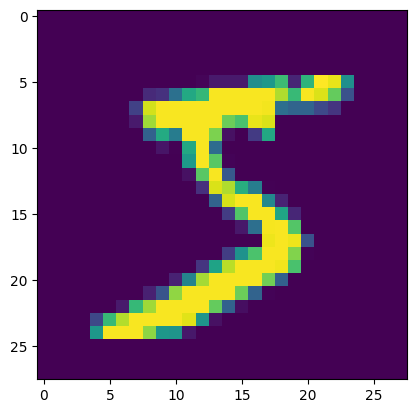

In [56]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

# 3.6.2 신경망의 추론 원리

이제 mnist 데이터셋으로 신경망을 구현해보자.

* 입력층: 784 뉴런 (28 x 28)
* 출력층: 10 뉴런

가중치는 미리 저장된 것을 불러다 읽는다. 이건 어쩔 수 없이 깃허브에서 받아와야 할 듯 하다.

In [14]:
import pickle
from lib.activation import sigmoid, softmax, softmax2

def get_data():
    (train_x, train_y), (test_x, test_y) = load_data()
    train_x = train_x.reshape(-1, 784) / 255.
    test_x = test_x.reshape(-1, 784) / 255.

    # train_x = train_x.flatten() / 255.
    # test_x = test_x.flatten() / 255.
    return test_x, test_y

def init_network():
    with open("lib/sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    # print('input shape:', b1.shape)

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

In [16]:
x, lb = get_data()
network = init_network()
accuracy_cnt = 0

print(x.shape, len(x), lb)

for i in range(len(x)):
    # print(x[i].shape)
    y = predict(network, x[i])
    # print(y.shape)
    p = np.argmax(y)

    print(p, lb)

(10000, 784) 10000 [7 2 1 ... 4 5 6]
7 [7 2 1 ... 4 5 6]
2 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
0 [7 2 1 ... 4 5 6]
4 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
4 [7 2 1 ... 4 5 6]
9 [7 2 1 ... 4 5 6]
6 [7 2 1 ... 4 5 6]
9 [7 2 1 ... 4 5 6]
0 [7 2 1 ... 4 5 6]
6 [7 2 1 ... 4 5 6]
9 [7 2 1 ... 4 5 6]
0 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
5 [7 2 1 ... 4 5 6]
9 [7 2 1 ... 4 5 6]
7 [7 2 1 ... 4 5 6]
3 [7 2 1 ... 4 5 6]
4 [7 2 1 ... 4 5 6]
9 [7 2 1 ... 4 5 6]
6 [7 2 1 ... 4 5 6]
6 [7 2 1 ... 4 5 6]
5 [7 2 1 ... 4 5 6]
4 [7 2 1 ... 4 5 6]
0 [7 2 1 ... 4 5 6]
7 [7 2 1 ... 4 5 6]
4 [7 2 1 ... 4 5 6]
0 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
3 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
3 [7 2 1 ... 4 5 6]
6 [7 2 1 ... 4 5 6]
7 [7 2 1 ... 4 5 6]
2 [7 2 1 ... 4 5 6]
7 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
2 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
7 [7 2 1 ... 4 5 6]
4 [7 2 1 ... 4 5 6]
2 [7 2 1 ... 4 5 6]
3 [7 2 1 ... 4 5 6]
5 [7 2 1 ... 4 5 6]
1 [7 2 1 ... 4 5 6]
2 [7 2 1 ... 4 5 6]
4 [